In [38]:
import torch
from torch.utils.data import Dataset
from utils.postprocessing.utils import files2dfs_maps

import glob

import matplotlib.pyplot as plt

import sklearn.pipeline
import sklearn.dummy
import sklearn.preprocessing
import sklearn.metrics.regression
from sklearn.metrics import auc, roc_curve
import skimage.transform


In [22]:
DATASET_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/dataset/'
MAPS_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/maps/'

csv_paths = glob.glob(DATASET_FOLDER + '/*/**.csv')

In [31]:
import torch
from torch.utils.data import Dataset
from utils.postprocessing.utils import files2dfs_maps
import numpy as np
import glob

import sklearn.pipeline
import sklearn.dummy
import sklearn.preprocessing
import sklearn.metrics.regression
from sklearn.metrics import auc, roc_curve
import skimage.transform


class TraversabilityDataset(Dataset):
    def __init__(self, data, patch_size=80):
        self.data = data
        self.patch_size = patch_size
        self.inputs = []
        self.targets = []

        for df, hm in self.data:
            if len(df) == 0: continue
            im, l = self.sample(df, hm, patch_size)
            self.inputs.append(im[:, :, np.newaxis])
            self.targets.append(l)

        self.inputs = np.array( self.inputs).astype('float32')
        self.targets = np.array(self.targets).astype('int')

    def sample(self, df, hm, sz):
        d = df.sample(1)
        l = d["label"].iloc[0]
        # hm = hms[d["hm"].iloc[0]]
        patch = self.hmpatch(hm, d["hm_x"].iloc[0], d["hm_y"].iloc[0], np.rad2deg(d["pose__pose_e_orientation_z"].iloc[0]),
                     self.patch_size, scale=1)[0]
        patch = self.transform_patch(patch, sz)
        return patch, l

    def hmpatch(self, hm, x, y, alpha, edge, scale=1):
        # Cutout a patch from the image, centered on (x,y), rotated by alpha
        # degrees (0 means bottom in hm remains bottom in patch, 90 means bottom in hm becomes right in patch),
        # with a specified edge size (in pixels) and scale (relative).
        tf1 = skimage.transform.SimilarityTransform(translation=[-x, -y])
        tf2 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(alpha))
        tf3 = skimage.transform.SimilarityTransform(scale=scale)
        tf4 = skimage.transform.SimilarityTransform(translation=[+edge / 2, +edge / 2])
        tf = (tf1 + (tf2 + (tf3 + tf4))).inverse
        # corners=tf(np.array([[0,0],[1,0],[1,1],[0,1]])*edge)
        corners = tf(np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]]) * edge)
        patch = skimage.transform.warp(hm, tf, output_shape=(edge, edge), mode="edge")
        return patch, corners

    def transform_patch(self, patch, sz):
        t_patch = patch - patch[patch.shape[0] // 2, patch.shape[1] // 2]
        t_patch = skimage.transform.resize(t_patch, (self.patch_size, self.patch_size), mode='constant')
        return t_patch

    def __getitem__(self, item):

        return self.inputs[item], self.targets[item]

    def __len__(self):
        return len(self.targets)

DATASET_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/dataset/'
MAPS_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/maps/'

csv_paths = glob.glob(DATASET_FOLDER + '/*/**.csv')


In [29]:
dfs_maps = dfs_maps = files2dfs_maps(csv_paths)

145


In [32]:
ds = TraversabilityDataset(dfs_maps)
print(len(ds))

145


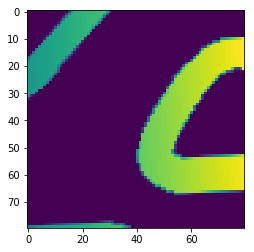

(80, 80, 1) 0


In [40]:
x, y = ds[0]

plt.imshow(x.squeeze())
plt.show()
print(x.shape, y)
